# Amazon Reviews Dataset

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [ ]:
train = pd.read_csv("./train_sampled_reviews.csv")
val = pd.read_csv("./val_sampled_reviews.csv")
test = pd.read_csv("./test_sampled_reviews.csv")

In [ ]:
train_texts = train['Review'].to_numpy()
train_labels = train['Label'].to_numpy()
val_texts = val['Review'].to_numpy()
val_labels = val['Label'].to_numpy()
test_texts = test['Review'].to_numpy()
test_labels = test['Label'].to_numpy()

y_train = to_categorical(train_labels, 2)
y_val = to_categorical(val_labels, 2)
y_test = to_categorical(test_labels, 2)

# Universal Sentence Encoder

In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

tf.random.set_seed(42)
model_USE = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
], name="model_USE")

model_USE.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

model_USE.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 256830786 (979.73 MB)
Trainable params: 32962 (128.76 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
checkpoint_path = "best_model_USE"
cc = ModelCheckpoint(filepath=checkpoint_path,
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True,
                     verbose=1)

In [ ]:
model_USE_history = model_USE.fit(train_texts, y_train,
                                  epochs=10,
                                  validation_data=(val_texts, y_val),
                                  callbacks=[cc])

Epoch 1/10
747/750 [============================>.] - ETA: 0s - loss: 0.3340 - accuracy: 0.8619
Epoch 1: val_accuracy improved from -inf to 0.87361, saving model to best_model_USE
750/750 [==============================] - 24s 25ms/step - loss: 0.3342 - accuracy: 0.8618 - val_loss: 0.2934 - val_accuracy: 0.8736
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.8772
Epoch 2: val_accuracy improved from 0.87361 to 0.88861, saving model to best_model_USE
750/750 [==============================] - 19s 26ms/step - loss: 0.2904 - accuracy: 0.8772 - val_loss: 0.2750 - val_accuracy: 0.8886
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8793
Epoch 3: val_accuracy did not improve from 0.88861
750/750 [==============================] - 11s 15ms/step - loss: 0.2829 - accuracy: 0.8793 - val_loss: 0.2708 - val_accuracy: 0.8856
Epoch 4/10
747/750 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

113/113 [==============================] - 2s 12ms/step - loss: 0.2076 - accuracy: 0.9164


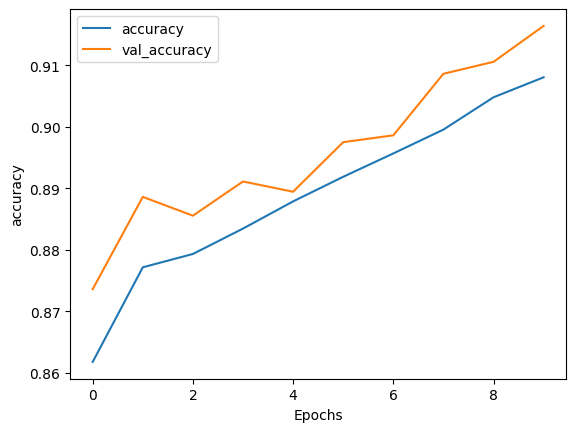

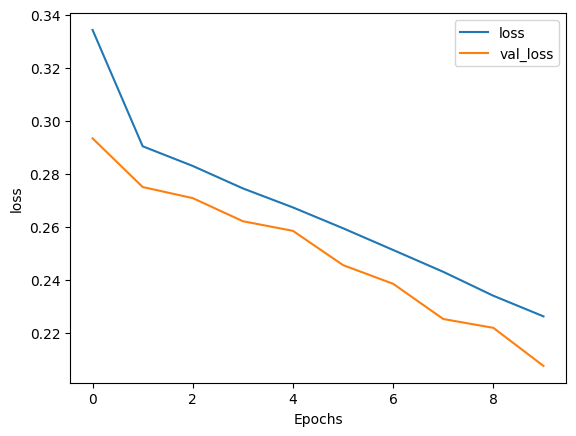

113/113 [==============================] - 2s 12ms/step


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model_USE = load_model(checkpoint_path)
model_USE.evaluate(val_texts, y_val)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(model_USE_history, 'accuracy')
plot_graphs(model_USE_history, 'loss')

model_USE_pred_probs = model_USE.predict(val_texts)

model_USE_preds = tf.argmax(model_USE_pred_probs, axis=1)
model_USE_results = calculate_results(val_labels, model_USE_preds)


In [ ]:
best_use = load_model(checkpoint_path)
score_use, acc_use = best_use.evaluate(val_texts, y_val, verbose=0)
print("Baseline USE Model on Amazon Reviews Dataset")
print(f'Test loss for USE model: {score_use:.3f}')
print(f'Test accuracy for USE model: {acc_use:.3f}')
print()

Baseline USE Model on Amazon Reviews Dataset
Test loss for USE model: 0.208
Test accuracy for USE model: 0.916



# Testing on Yelp

In [ ]:
yelp_df = pd.read_csv('yelp_test.csv')

In [ ]:
yelp_df = yelp_df.drop(['Unnamed: 0'], axis=1)

In [ ]:
yelp_df

,Label,Review
0,1,I visited Le Taj for their lunch buffet and re...
1,0,Have to say this location totally dropped the ...
2,0,I received a recommendation to eat here from t...
3,1,Tried the Triple Bypass Burger with bacon. It ...
4,0,Although the severs and staff are extremely fr...
...,...,...
5694,1,Excellent in every aspect. Had the White Fish...
5695,1,The food is pretty authentic made fresh and a ...
5696,0,having been to Fuego for group events I though...
5697,0,Do not go here for late night dinner hours. Th...


Epoch 1/10
416/416 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9012
Epoch 1: val_accuracy improved from -inf to 0.90876, saving model to /content/drive/MyDrive/advanced_project/models/best_use_yelp_model
416/416 [==============================] - 31s 68ms/step - loss: 0.2349 - accuracy: 0.9012 - val_loss: 0.2251 - val_accuracy: 0.9088
Epoch 2/10
416/416 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9111
Epoch 2: val_accuracy improved from 0.90876 to 0.91156, saving model to /content/drive/MyDrive/advanced_project/models/best_use_yelp_model
416/416 [==============================] - 29s 71ms/step - loss: 0.2144 - accuracy: 0.9111 - val_loss: 0.2187 - val_accuracy: 0.9116
Epoch 3/10
416/416 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9163
Epoch 3: val_accuracy did not improve from 0.91156
416/416 [==============================] - 22s 53ms/step - loss: 0.2050 - accuracy: 0.9163 - val_loss: 0.2197 - val_accu

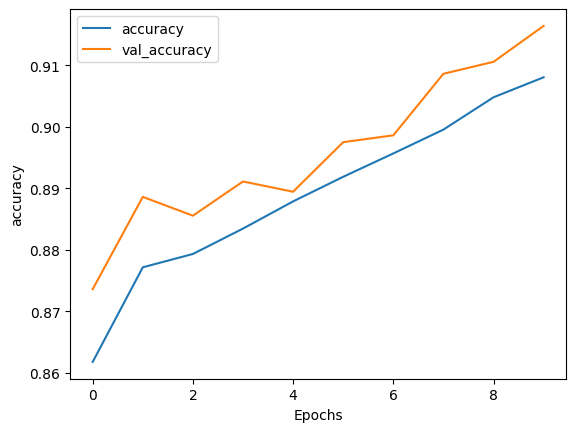

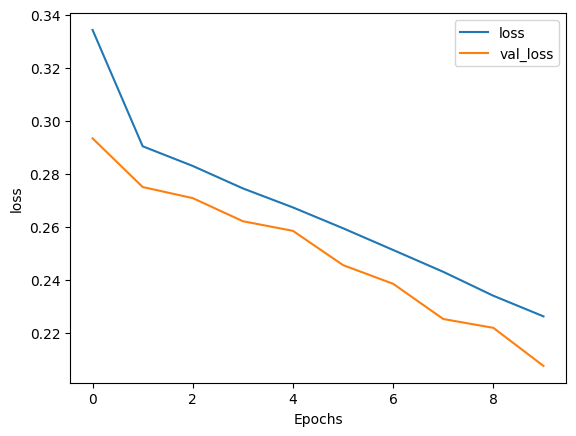

179/179 [==============================] - 4s 22ms/step


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

train = pd.read_csv("./yelp_train.csv")
val = pd.read_csv("./yelp_val.csv")
test = pd.read_csv("./yelp_test.csv")

train_texts = train['Review'].to_numpy()
train_labels = train['Label'].to_numpy()
val_texts = val['Review'].to_numpy()
val_labels = val['Label'].to_numpy()
test_texts = test['Review'].to_numpy()
test_labels = test['Label'].to_numpy()

y_train = to_categorical(train_labels, 2)
y_val = to_categorical(val_labels, 2)
y_test = to_categorical(test_labels, 2)

model_best_use_yelp = load_model(checkpoint_path)

optimizer = Adam(learning_rate=0.001)
model_best_use_yelp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

best_use_yelp_checkpoint_path = '/content/drive/MyDrive/advanced_project/models/best_use_yelp_model'
best_use_yelp_checkpoint = ModelCheckpoint(
    filepath=best_use_yelp_checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

y_train_y = to_categorical(np.array(train_labels).astype('int'), 2)
y_val_y = to_categorical(np.array(val_labels).astype('int'), 2)

history_use_ft = model_best_use_yelp.fit(
    train_texts, y_train_y,
    batch_size=64,
    validation_data=(val_texts, y_val_y),
    epochs=10,
    callbacks=[best_use_yelp_checkpoint]
)

model_best_use_yelp.evaluate(val_texts, y_val)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(model_USE_history, 'accuracy')
plot_graphs(model_USE_history, 'loss')
model_USE_pred_probs = model_USE.predict(val_texts)
model_USE_preds = tf.argmax(model_USE_pred_probs, axis=1)
model_USE_results = calculate_results(val_labels, model_USE_preds)

In [ ]:
best_use_yelp_model = load_model(best_use_yelp_checkpoint_path)
score_use, acc_use = best_use_yelp_model.evaluate(val_texts, y_val, verbose=0)
print("Baseline USE Model on Yelp Dataset")
print(f'Test loss for USE model: {score_use:.3f}')
print(f'Test accuracy for USE model: {acc_use:.3f}')
print()

Baseline USE Model on Yelp Dataset
Test loss for USE model: 0.214
Test accuracy for USE model: 0.915



# Finetuning the Model on Yelp

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

model_use_finetuned = load_model(checkpoint_path)

optimizer = Adam(learning_rate=0.001)

model_use_finetuned.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

use_finetune_checkpoint_path = '/content/drive/MyDrive/advanced_project/models/use_finetuned_best_model'
use_finetune_checkpoint = ModelCheckpoint(
    filepath=use_finetune_checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

y_train_y = to_categorical(np.array(train_labels).astype('int'), 2)
y_val_y = to_categorical(np.array(val_labels).astype('int'), 2)

history_use_ft = model_use_finetuned.fit(
    train_texts, y_train_y,
    batch_size=256,
    validation_data=(val_texts, y_val_y),
    epochs=10,
    callbacks=[use_finetune_checkpoint]
)


Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.8998
Epoch 1: val_accuracy improved from -inf to 0.90683, saving model to /content/drive/MyDrive/advanced_project/models/use_finetuned_best_model
104/104 [==============================] - 31s 263ms/step - loss: 0.2406 - accuracy: 0.8998 - val_loss: 0.2295 - val_accuracy: 0.9068
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9088
Epoch 2: val_accuracy improved from 0.90683 to 0.90946, saving model to /content/drive/MyDrive/advanced_project/models/use_finetuned_best_model
104/104 [==============================] - 29s 285ms/step - loss: 0.2203 - accuracy: 0.9088 - val_loss: 0.2235 - val_accuracy: 0.9095
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9124
Epoch 3: val_accuracy improved from 0.90946 to 0.91069, saving model to /content/drive/MyDrive/advanced_project/models/use_finetuned_best_model
104/104 [======

In [ ]:
finetune_use_best = load_model(use_finetune_checkpoint_path)

y_test_y = np.array(test_labels)
y_test_y = y_test_y.astype('int')
y_test_y = to_categorical(y_test_y, 2)
score_use, acc_use = best_use.evaluate(test_texts, y_test_y, verbose=0)

print("Finetuned USE Model on Yelp Dataset")
print(f'Test loss for Fine-Tuned USE model: {score_use:.3f}')
print(f'Test accuracy for Fine-Tuned USE model: {acc_use:.3f}')
print()

Finetuned USE Model on Yelp Dataset
Test loss for Fine-Tuned USE model: 0.272
Test accuracy for Fine-Tuned USE model: 0.886



# Feature Extraction on the Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

pretrained_model = load_model(use_finetune_checkpoint_path)

dropout_rate = 0.5
x = Dropout(dropout_rate)(pretrained_model.layers[-2].output)
output = Dense(units=pretrained_model.layers[-1].units, activation=pretrained_model.layers[-1].activation)(x)
model = Model(inputs=pretrained_model.input, outputs=output)

for layer in model.layers[:-2]:
    layer.trainable = False

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

use_feature_extraction_checkpoint_path = '/content/drive/MyDrive/advanced_project/models/use_feature_extraction_best_model'
checkpoint = ModelCheckpoint(filepath=use_feature_extraction_checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

batch_size = 128

history = model.fit(
    train_texts, y_train_y,
    batch_size=batch_size,
    validation_data=(val_texts, y_val_y),
    epochs=10,
    callbacks=[checkpoint, lr_scheduler]
)


Epoch 1/10
208/208 [==============================] - 30s 129ms/step - loss: 0.4032 - accuracy: 0.8717 - val_loss: 0.2948 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 2/10
208/208 [==============================] - 28s 136ms/step - loss: 0.2705 - accuracy: 0.9071 - val_loss: 0.2436 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 3/10
208/208 [==============================] - 27s 130ms/step - loss: 0.2385 - accuracy: 0.9095 - val_loss: 0.2269 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 4/10
208/208 [==============================] - 29s 141ms/step - loss: 0.2242 - accuracy: 0.9125 - val_loss: 0.2201 - val_accuracy: 0.9116 - lr: 0.0010
Epoch 5/10
208/208 [==============================] - 27s 129ms/step - loss: 0.2197 - accuracy: 0.9120 - val_loss: 0.2170 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 6/10
208/208 [==============================] - 29s 140ms/step - loss: 0.2156 - accuracy: 0.9146 - val_loss: 0.2153 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 7/10
208/208 [==============================] 

In [ ]:
use_feature_extraction_best_two = load_model(use_feature_extraction_checkpoint_path)

y_test_y = np.array(test_labels)
y_test_y = y_test_y.astype('int')
y_test_y = to_categorical(y_test_y, 2)
score_use, acc_use = best_use.evaluate(test_texts, y_test_y, verbose=0)

print("Feature Extraction USE Model on Yelp Dataset")
print(f'Test loss for Fine-Tuned USE model: {score_use:.3f}')
print(f'Test accuracy for Fine-Tuned USE model: {acc_use:.3f}')
print()

Feature Extraction USE Model on Yelp Dataset
Test loss for Fine-Tuned USE model: 0.272
Test accuracy for Fine-Tuned USE model: 0.886

